<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.09/CV/1_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2023-02-09/4차시

/content/drive/MyDrive/2023-02-09/4차시


# Bounding Box 및 IoU  - #0

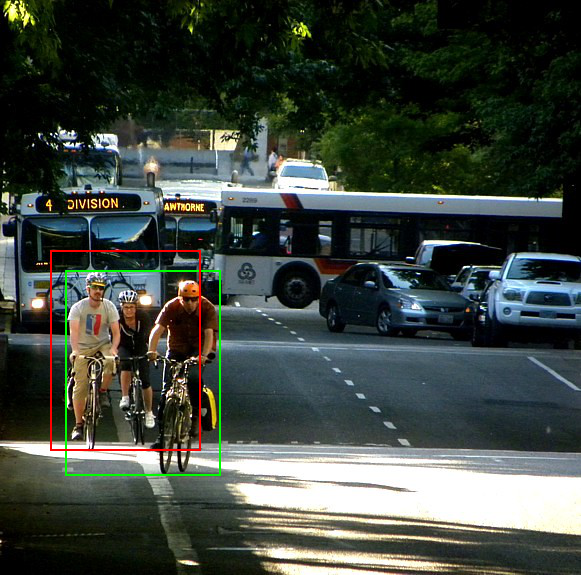

In [ ]:
from PIL import Image, ImageDraw

# 색상 지정 Green, Red
color = [(0, 255, 0), (255, 0, 0)]

# 이미지 및 bounding box
img = Image.open('images/coco/coco.png')
boxes = [[65, 270, 220, 475],
         [50, 250, 200, 450]]

# PIL image에 그리기
draw = ImageDraw.Draw(img)

# image에 bounding box 그리기
for i, box in enumerate(boxes):
  draw.rectangle(box, outline=color[i], width=2)

img

In [ ]:
# bounding box
box1, box2 = boxes[0], boxes[1]

# 각 bounding box의 면적
box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

# 중복 영역의 좌표 계산
x1 = max(box1[0], box2[0])
y1 = max(box1[1], box2[1])
x2 = min(box1[2], box2[2])
y2 = min(box1[3], box2[3])

# 중복 영역의 크기 계산
w = max(0, x2 - x1 + 1)
h = max(0, y2 - y1 + 1)

# 중복 영역 면적
inter = w * h

# iou 계산
iou = inter / (box1_area + box2_area - inter)

print(f'Overlap: {inter}')
print(f'Union: {box1_area + box2_area - inter}')
print(f'IoU: {iou}')

Overlap: 24616
Union: 37159
IoU: 0.6624505503377378


# 환경 설정 - #1

In [ ]:
%%shell

# 관련 API 설치
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-glxkxfqs
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-glxkxfqs
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=421024 sha256=943e3f83037b3a02d98c49a1cd10ffff97eedc6c49a78d8817de866f195b8192
  Stored in directory: /tmp/pip-ephem-wheel-cache-gsbd9pt0/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.

In [ ]:
%%shell

# 보행자 데이터셋 다운로드
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .

# 데이터셋 압축 풀기
unzip PennFudanPed.zip

--2023-02-09 01:40:06--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  53.7MB/s    in 1.0s    

2023-02-09 01:40:07 (53.7 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-02-09 01:40:07--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-02-09 01:40:07--
Total wall clock time: 1.1s
Downloaded: 1 files, 51M in 1.0s (53.7 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
%%shell

# Torchvision 베이스라인 다운로드
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 295334, done.
remote: Counting objects: 100% (5126/5126), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 295334 (delta 4804), reused 5044 (delta 4758), pack-reused 290208
Receiving objects: 100% (295334/295334), 591.64 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (270733/270733), done.
Updating files: 100% (867/867), done.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/android/scripts/install_gradle.sh
	.circleci/unittest/ios/scripts/binary_ios_build.sh
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	android/gradlew
	ios/VisionTestApp/clean.sh
	ios/VisionTestApp/setup.sh
	ios/build_ios.sh
	packaging

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image

# torchvision 모델 관련 라이브러리
import torchvision
import torchvision.models.detection.faster_rcnn as faster_rcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# torchvision object detection baseline
import transforms as T
from engine import train_one_epoch, evaluate
import utils

# 데이터셋 준비 - #2

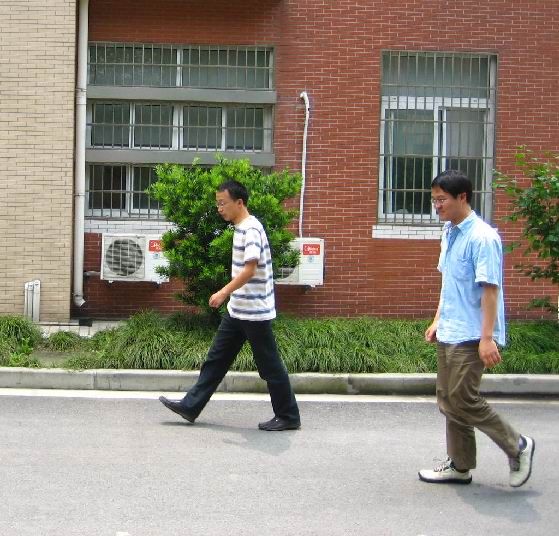

In [ ]:
# 데이터 확인
img = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
img

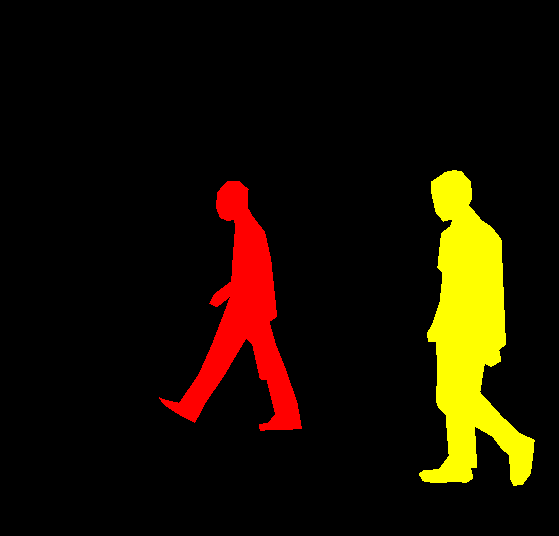

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')

mask.putpalette([
    0, 0, 0, # 배경
    255, 0, 0, # index 1: red
    255, 255, 0, # index 2: yellow
    255, 153, 0, # index 3: orange
])
mask

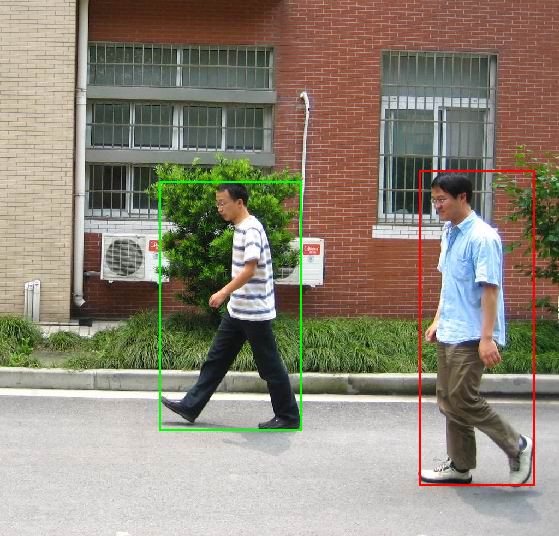

In [ ]:
# 이미지 내 객체 카테고리
obj_ids = np.unique(mask)

# 0번 객체는 배경이기 때문에 제거
obj_ids = obj_ids[1:]

# 다중 마스크를 이진 마스크로 변환
mask = np.array(mask)
masks = mask == obj_ids[:, None, None]

# 각 마스크의 바운딩 박스 좌표 계산
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

# 색상 지정 Green, Red
color = [(0, 255, 0), (255, 0, 0)]

# PIL image에 그리기
draw = ImageDraw.Draw(img)

# image에 bounding box 그리기
for i, box in enumerate(boxes):
  draw.rectangle(box, outline=color[i], width=2)

img

In [ ]:
# 보행자 데이터셋
class PennFudanDataset(torch.utils.data.Dataset):
    # 데이터셋 구성 설정
    def __init__(self, root, transforms=None):
        # 데이터셋 경로
        self.root = root

        # 데이터 증강
        self.transforms = transforms
        
        # 이미지 및 마스크 파일 경로
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지 및 마스크 파일 경로
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # 이미지 및 마스크 불러오기
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # 이미지 내 객체 카테고리
        obj_ids = np.unique(mask)

        # 0번 객체는 배경이기 때문에 제거
        obj_ids = obj_ids[1:]

        # 다중 마스크를 이진 마스크로 변환
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표 계산
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # 사람을 label로 생성
        labels = torch.ones((num_objs,), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        # 바운딩 박스 크기
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 평가에서 제외할 객체
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # 바운딩 박스, 레이블 정보
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # 이미지 증강
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        # 이미지 및 레이블 정보 반환
        return img.type(torch.FloatTensor), target

    # 데이터 개수
    def __len__(self):
        return len(self.imgs)

In [ ]:
# 데이터 증강
train_transforms = T.Compose([T.PILToTensor()])
test_transforms = T.Compose([T.PILToTensor()])

# 데이터셋 생성
train_data = PennFudanDataset(root='PennFudanPed/', transforms=train_transforms)
test_data = PennFudanDataset(root='PennFudanPed/', transforms=test_transforms)

# train, test 구분
indices = torch.randperm(len(train_data)).tolist()
train_data = torch.utils.data.Subset(train_data, indices[:-50])
test_data = torch.utils.data.Subset(test_data, indices[-50:])

# target
train_data[0][1]

{'boxes': tensor([[243.,  41., 389., 328.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([104]),
 'area': tensor([41902.]),
 'iscrowd': tensor([0])}

In [ ]:
# 데이터 개수
print(f'학습 데이터: {len(train_data)}')
print(f'시험 데이터: {len(test_data)}')

학습 데이터: 120
시험 데이터: 50


In [ ]:
# 데이터 로더
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, collate_fn=utils.collate_fn)

# 모델 생성 - #3

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# 사전 학습된 faster rcnn 불러오기
model = faster_rcnn.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
image = torchvision.transforms.ToTensor()(Image.open('images/coco/coco2.png').convert('RGB'))

model.eval()
with torch.no_grad():
  pred = model([image.to(device)])

pred

[{'boxes': tensor([[1.8335e+02, 6.4167e+01, 2.9169e+02, 1.9082e+02],
          [8.1843e+00, 7.8494e+01, 5.4322e+01, 1.6119e+02],
          [5.4609e+02, 1.1721e+02, 5.8346e+02, 1.9375e+02],
          [3.8949e+02, 8.5502e+01, 4.1948e+02, 1.1712e+02],
          [8.1869e-01, 2.1162e+02, 4.6326e+01, 3.2703e+02],
          [5.9076e+02, 1.0570e+02, 6.2935e+02, 2.3279e+02],
          [2.5887e+02, 8.5825e+01, 3.1479e+02, 1.8698e+02],
          [6.3627e-01, 1.6180e+02, 5.5441e+01, 2.6000e+02],
          [2.8554e+02, 7.7258e+01, 3.2306e+02, 1.4558e+02],
          [4.4236e+02, 9.9840e+01, 4.6494e+02, 1.1910e+02],
          [4.1373e+02, 9.8730e+01, 4.3380e+02, 1.1790e+02],
          [2.7048e+01, 9.1181e+01, 6.2641e+02, 4.2497e+02],
          [3.8124e+00, 1.0739e+02, 2.1898e+02, 2.5693e+02],
          [0.0000e+00, 1.0919e+02, 1.4379e+01, 1.5583e+02],
          [1.7927e+02, 1.0040e+02, 1.8989e+02, 1.1126e+02],
          [5.7545e+02, 1.1104e+02, 5.9777e+02, 1.4855e+02],
          [8.1615e+01, 1.0530e+

In [ ]:
cocolabel = ['', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
             'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
             'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses',
             'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
             'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
             'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
             'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet',
             'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
             'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',
             'hair brush'
             ]
len(cocolabel)

92

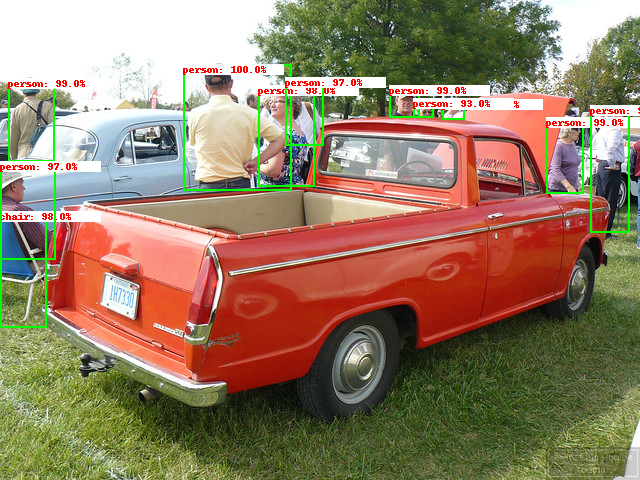

In [ ]:
# tensor를 PIL image로 변환
img = to_pil_image(image)

# PIL image에 그리기
draw = ImageDraw.Draw(img)

# image에 bounding box 그리기
for i in range(len(pred[0]['boxes'])):
  box = pred[0]['boxes'][i].detach().cpu().numpy()
  label = pred[0]['labels'][i].detach().cpu().numpy()
  score = pred[0]['scores'][i].detach().cpu().numpy()
  
  # confidence score가 0.9 이상인 객체만 그리기
  if score > 0.9:
    # Bounding box
    draw.rectangle(box, outline=(0, 255, 0), width=2)

    # Text box
    draw.rectangle((box[0], box[1], box[0]+100, box[1]+10), outline=(255, 255, 255), width=10)
    draw.text((box[0], box[1]), f'{cocolabel[label]}: {round(score*100, 0)}%', (255,0,0))
    
img

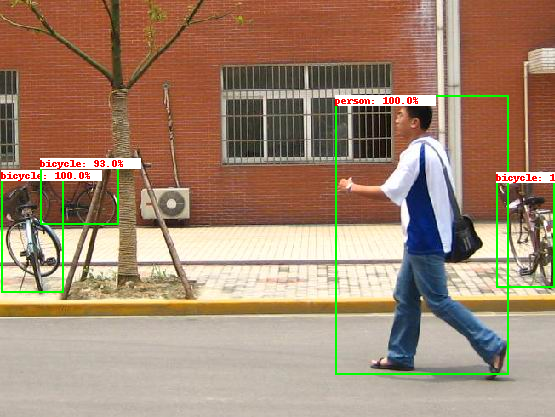

In [ ]:
# 보행자 데이터셋에 적용
image = torchvision.transforms.ToTensor()(Image.open('PennFudanPed/PNGImages/FudanPed00020.png').convert('RGB'))

model.eval()
with torch.no_grad():
  pred = model([image.to(device)])

# tensor를 PIL image로 변환
img = to_pil_image(image)

# PIL image에 그리기
draw = ImageDraw.Draw(img)

# image에 bounding box 그리기
for i in range(len(pred[0]['boxes'])):
  box = pred[0]['boxes'][i].detach().cpu().numpy()
  label = pred[0]['labels'][i].detach().cpu().numpy()
  score = pred[0]['scores'][i].detach().cpu().numpy()
  
  # confidence score가 0.9 이상인 객체만 그리기
  if score > 0.9:
    # Bounding box
    draw.rectangle(box, outline=(0, 255, 0), width=2)

    # Text box
    draw.rectangle((box[0], box[1], box[0]+100, box[1]+10), outline=(255, 255, 255), width=10)
    draw.text((box[0], box[1]), f'{cocolabel[label]}: {round(score*100, 0)}%', (255,0,0))
    
img

In [ ]:
# faster rcnn 모델 생성
def get_faster_rcnn():
  # 사전학습된 모델 불러오기
  model = faster_rcnn.fasterrcnn_resnet50_fpn(pretrained=True)

  # 사람 or 배경
  num_classes = 2

  # 분류기에 사용될 입력 특징의 차원
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # 분류기 설정
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = get_faster_rcnn().to(device)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# 모델 학습 - #4

In [ ]:
# 모델 백본 프리징
for p in model.parameters():
  p.require_grad = False

for p in model.roi_heads.box_predictor.parameters():
  p.require_grad = True

In [ ]:
# 옵티마이저 설정
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00005)

In [ ]:
epochs = 10

for epoch in range(epochs):
    # 학습
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    
    # 평가
    evaluate(model, test_loader, device=device)

Epoch: [0]  [ 0/30]  eta: 0:00:58  lr: 0.000004  loss: 92.2568 (92.2568)  loss_classifier: 31.8103 (31.8103)  loss_box_reg: 0.9412 (0.9412)  loss_objectness: 58.2809 (58.2809)  loss_rpn_box_reg: 1.2244 (1.2244)  time: 1.9591  data: 0.0704  max mem: 5976
Epoch: [0]  [10/30]  eta: 0:00:22  lr: 0.000038  loss: 8.7782 (30.7112)  loss_classifier: 2.7264 (9.0676)  loss_box_reg: 1.3956 (1.3115)  loss_objectness: 5.7718 (19.3658)  loss_rpn_box_reg: 0.6792 (0.9663)  time: 1.1145  data: 0.0648  max mem: 5976
Epoch: [0]  [20/30]  eta: 0:00:11  lr: 0.000072  loss: 5.3303 (18.8933)  loss_classifier: 1.3255 (5.2718)  loss_box_reg: 1.0487 (1.1107)  loss_objectness: 1.6942 (11.6334)  loss_rpn_box_reg: 0.6599 (0.8774)  time: 1.0668  data: 0.0680  max mem: 6019
Epoch: [0]  [29/30]  eta: 0:00:01  lr: 0.000100  loss: 2.7134 (13.8961)  loss_classifier: 0.5830 (3.8383)  loss_box_reg: 0.6447 (0.9523)  loss_objectness: 0.8802 (8.4153)  loss_rpn_box_reg: 0.3266 (0.6903)  time: 1.1122  data: 0.0725  max mem: 69

# 모델 출력 확인 - #5

In [ ]:
# 테스트 이미지
img, _ = test_data[0]

# 모델 출력 확인
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction

[{'boxes': tensor([[ 27.5062,  50.0231, 113.8282, 325.7461],
          [217.9952,  62.4607, 288.8424, 322.6800],
          [ 61.6266,  75.0020, 131.8560, 323.8675],
          [  5.2103,  77.6448,  74.4994, 299.1865],
          [196.5840,  34.1370, 266.8554, 312.0601],
          [384.7591,  37.9314, 453.9754, 253.4954],
          [348.9035, 104.7548, 453.4123, 234.2307],
          [329.3527,  25.0541, 444.7887, 334.0617],
          [244.0910,  31.8434, 310.0731, 333.6311],
          [342.4940,  21.5893, 413.8014, 257.9266],
          [273.7146,  47.3321, 338.0833, 288.1822],
          [ 23.6090,  53.9518,  62.2853, 152.7933],
          [299.6483,  31.4147, 368.3706, 267.3470],
          [189.7755,   0.0000, 306.3130, 348.8737],
          [165.1091,  38.6532, 236.7742, 276.5636],
          [  8.6153, 152.7681,  91.5969, 286.5105],
          [272.6429,  30.6396, 385.9220, 354.0000],
          [ 59.5030,  24.1307, 126.7998, 237.6764],
          [400.1698, 117.6358, 434.8478, 218.0001],
   

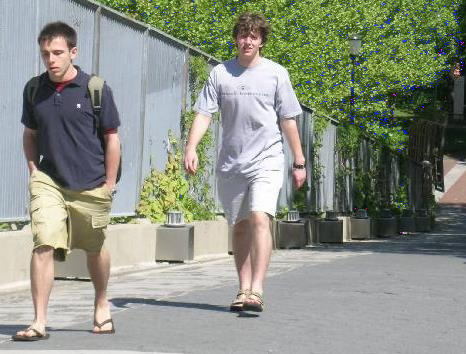

In [ ]:
# tensor를 PIL image로 변환
img = to_pil_image(img)
for i in range(0,img.size[0]):
    for j in range(0,img.size[1]):
        rgb = img.getpixel((i,j))
        rgb_r = (255-rgb[0], 255-rgb[1], 255-rgb[2])
        img.putpixel((i,j), rgb_r)

# PIL image에 그리기
draw = ImageDraw.Draw(img)

# image에 bounding box 그리기
for box, score in zip(prediction[0]['boxes'], prediction[0]['scores']):
  if score > 0.9:
    draw.rectangle(box.detach().cpu().numpy(), outline=(0, 255, 0), width=2)

img